# Emotion Classifier with Pytorch


In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import librosa
import torch 
import torchaudio
from torch.utils.data import Dataset



if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

Using device cpu


In [61]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

In [53]:
import pandas as pd 
import numpy as np 
import os 
import torch 
import torchaudio
from torch.utils.data import Dataset




# Global variables 

SAMPLE_RATE = 16000
N_FFT = int(0.025 * SAMPLE_RATE)   # 25 ms 
HOP_LENGTH = int(0.01 * SAMPLE_RATE)  # 10 ms
N_MELS = 13

# Dataset Paths 

RAVDESS_dir = '/Users/stephen/Desktop/Emotion_Speech_Detection/data/RAVDESS'
RAVDESS_metadata = '/Users/stephen/Desktop/Emotion_Speech_Detection/data/metadata.csv'




# Class 

class RavdessDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 
                 target_sample_rate,
                 num_samples,
                 device, 
                 transformation=None):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # if there is any transform method, apply it to audio tensor
        if self.transformation:
            signal = self.transformation(signal).to(self.device)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = f"{self.annotations.iloc[index, 0]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 0])
        return fold

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 1]


if __name__ == "__main__":
    ANNOTATIONS_FILE = "/Users/stephen/Desktop/Emotion_Speech_Detection/data/metadata.csv"
    AUDIO_DIR = "/Users/stephen/Desktop/Emotion_Speech_Detection/data/RAVDESS"
    SAMPLE_RATE = 16000
    NUM_SAMPLES = 16000*4

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64, 
        normalized=True
    )
    

    rav = RavdessDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device, 
                            transformation=mel_spectrogram,)
    print(f"There are {len(rav)} samples in the dataset.")
    signal, label = rav[0]


Using device cpu
There are 1440 samples in the dataset.


In [54]:
rav[1][1]

'fear'

In [55]:
print(len(rav))

1440


In [56]:
# helper functions 

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())


# Explore Data

In [57]:
test_sample, test_label = rav[600]
print(test_label)

fear


In [58]:
print_stats(test_sample)

Shape: (1, 64, 126)
Dtype: torch.float32
 - Max:      0.433
 - Min:      0.000
 - Mean:     0.001
 - Std Dev:  0.013

tensor([[[1.1032e-12, 4.2937e-15, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.9745e-12, 4.6550e-15, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.6980e-12, 5.1064e-15, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.6413e-10, 1.1733e-12, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4725e-10, 1.0552e-12, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3712e-10, 9.5229e-13, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])



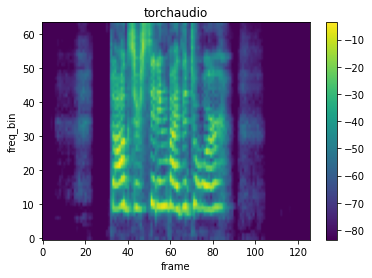

In [64]:
plot_spectrogram(test_sample[0], title='torchaudio')

# create training and validation sets

In [71]:
data_len = len(rav)
train_len = data_len * 0.7
test_len = data_len * 0.3
#val_len = data_len - (train_len + test_len)


train_data, test_data = torch.utils.data.random_split(rav, [train_len, test_len])

TypeError: randperm() received an invalid combination of arguments - got (float, generator=torch._C.Generator), but expected one of:
 * (int n, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int n, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
